# Import Packages and Dataset

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
import itertools

In [2]:
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')
val = pd.read_csv('mnist_val.csv')

# Filter Data for 3 and 5

In [3]:
#Filter each for only 3 and 5
train35 = train[train['label'].isin([3, 5])]
test35 = test[test['label'].isin([3, 5])]
val35 = val[val['label'].isin([3, 5])]

#One Hot Encode values into binary
train35["label"] = train35["label"].map({3: 0, 5: 1})
test35["label"] = test35["label"].map({3: 0, 5: 1})
val35["label"] = val35["label"].map({3: 0, 5: 1})

#Split into predictors and response variables
X_train35 = train35.iloc[:, 1:]
y_train35 = train35.iloc[:, 0]
X_test35 = test35.iloc[:, 1:]
y_test35 = test35.iloc[:, 0]
X_val35 = val35.iloc[:, 1:]
y_val35 = val35.iloc[:, 0]

C:\Users\julia\AppData\Local\Temp\ipykernel_7764\1197722052.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train35["label"] = train35["label"].map({3: 0, 5: 1})
C:\Users\julia\AppData\Local\Temp\ipykernel_7764\1197722052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test35["label"] = test35["label"].map({3: 0, 5: 1})
C:\Users\julia\AppData\Local\Temp\ipykernel_7764\1197722052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

# Filter Data for 4 and 9

In [4]:
# Filter for only 4 and 9
train49 = train[train['label'].isin([4, 9])]
test49 = test[test['label'].isin([4, 9])]
val49 = val[val['label'].isin([4, 9])]

#One Hot Encode values into binary
train49["label"] = train49["label"].map({4: 0, 9: 1})
test49["label"] = test49["label"].map({4: 0, 9: 1})
val49["label"] = val49["label"].map({4: 0, 9: 1})

#Split into predictors and response variables
X_train49 = train49.iloc[:, 1:]
y_train49 = train49.iloc[:, 0]
X_test49 = test49.iloc[:, 1:]
y_test49 = test49.iloc[:, 0]
X_val49 = val49.iloc[:, 1:]
y_val49 = val49.iloc[:, 0]

C:\Users\julia\AppData\Local\Temp\ipykernel_7764\2663030082.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train49["label"] = train49["label"].map({4: 0, 9: 1})
C:\Users\julia\AppData\Local\Temp\ipykernel_7764\2663030082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test49["label"] = test49["label"].map({4: 0, 9: 1})
C:\Users\julia\AppData\Local\Temp\ipykernel_7764\2663030082.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

# Part (a)

In [13]:
# Parameters
np.random.seed(406027534)
torch.manual_seed(406027534)
corr_factor = 0.5
flip_factor = 0.15
epochs = 30
batch_sizes = [64, 128, 256]
hidden_layers = [64, 128, 256] 
base_lr = 0.1
decay_rate = 0.7

def mlp(X_train, X_test, X_val, Y_train, Y_test, Y_val):
    # Define Variables
    n = X_train.shape[0]
    p = X_train.shape[1]
    
    # Convert to PyTorch tensors
    x_train = torch.tensor(np.array(X_train), dtype=torch.float32)
    y_train = torch.tensor(np.array(Y_train).reshape(-1, 1), dtype=torch.float32)
    x_val = torch.tensor(np.array(X_val), dtype=torch.float32)
    y_val = torch.tensor(np.array(Y_val).reshape(-1, 1), dtype=torch.float32)
    x_test = torch.tensor(np.array(X_test), dtype=torch.float32)
    y_test = torch.tensor(np.array(Y_test).reshape(-1, 1), dtype=torch.float32)
    
    # MLP model definition
    class MLPModel(nn.Module):
        def __init__(self, input_dim, hidden1):
            super(MLPModel, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden1) #input to hidden layer
            self.fc2 = nn.Linear(hidden1, 1) #hidden layer to output
            
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.sigmoid(self.fc2(x))
            return x
    
    # Track results and best model
    results = {}
    best_val_loss = float('inf')
    best_model = None
    best_config = None
    
    for batch_size in batch_sizes: #batch_size in [64, 128, 256]
        for h1 in hidden_layers: #each iteration tracks in number of hidden_layers in [64, 128, 256]
            
            # Print the model configuration being used
            print(f"Trying model with h1 = {h1}")
            
            # Initialize model and optimizer
            model = MLPModel(p, h1) #generate model with p predictors and hidden layers = h1
            optimizer = optim.SGD(model.parameters(), lr=base_lr) 
            loss_fn = nn.BCELoss()

            #Store training and validation loss
            train_loss_history = []
            val_loss_history = []
            
            # Create data loaders for training model
            train_dataset = TensorDataset(x_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #set minibatches
            
            for epoch in range(epochs):
                # Learning rate decay
                lr = base_lr * (decay_rate ** epoch)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                
                # Training loop
                model.train()
                for x_batch, y_batch in train_loader: 
                    optimizer.zero_grad()
                    y_pred = model(x_batch) #get prediction for y
                    loss = loss_fn(y_pred, y_batch) #check the loss by comparing predicted to actual
                    loss.backward()
                    optimizer.step()
                
                # Track training and validation loss
                model.eval()
                with torch.no_grad():
                    #get predictions for train and val
                    train_pred = model(x_train)
                    val_pred = model(x_val)

                    #get loss for train and val
                    train_loss = loss_fn(train_pred, y_train).item()
                    val_loss = loss_fn(val_pred, y_val).item()

                    #ROC values
                    val_probs = val_pred.numpy().flatten()
                    val_labels = y_val.numpy().flatten()
                    fpr, tpr, _ = roc_curve(val_labels, val_probs)
                    auc_score = roc_auc_score(val_labels, val_probs)

                #store in history
                train_loss_history.append(train_loss)
                val_loss_history.append(val_loss)

                
            
            # Store the results
            key = f"Batch_{batch_size}_Hidden_{h1}"
            results[key] = {'train': train_loss_history, 'val': val_loss_history, 'auc': auc_score, 'fpr': fpr, 'tpr': tpr}
            
            # Update best model if needed
            if min(val_loss_history) < best_val_loss:
                best_val_loss = min(val_loss_history)
                best_model = model
                best_config = key

    # Plotting ROC Curve
    plt.figure(figsize=(10, 8))
    for config, result in results.items():
        plt.plot(result['fpr'], result['tpr'], label=f"{config} (AUC = {result['auc']:.2f})")
    
    plt.plot([0, 1], [0, 1], linestyle='--', label = "Random")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    print(f"Best Model = {best_config} with AUC score = {results[best_config]['auc']}")

    return best_config 
    




## 3 and 5

Trying model with h1 = 64
Trying model with h1 = 128
Trying model with h1 = 256
Trying model with h1 = 64
Trying model with h1 = 128
Trying model with h1 = 256
Trying model with h1 = 64
Trying model with h1 = 128
Trying model with h1 = 256


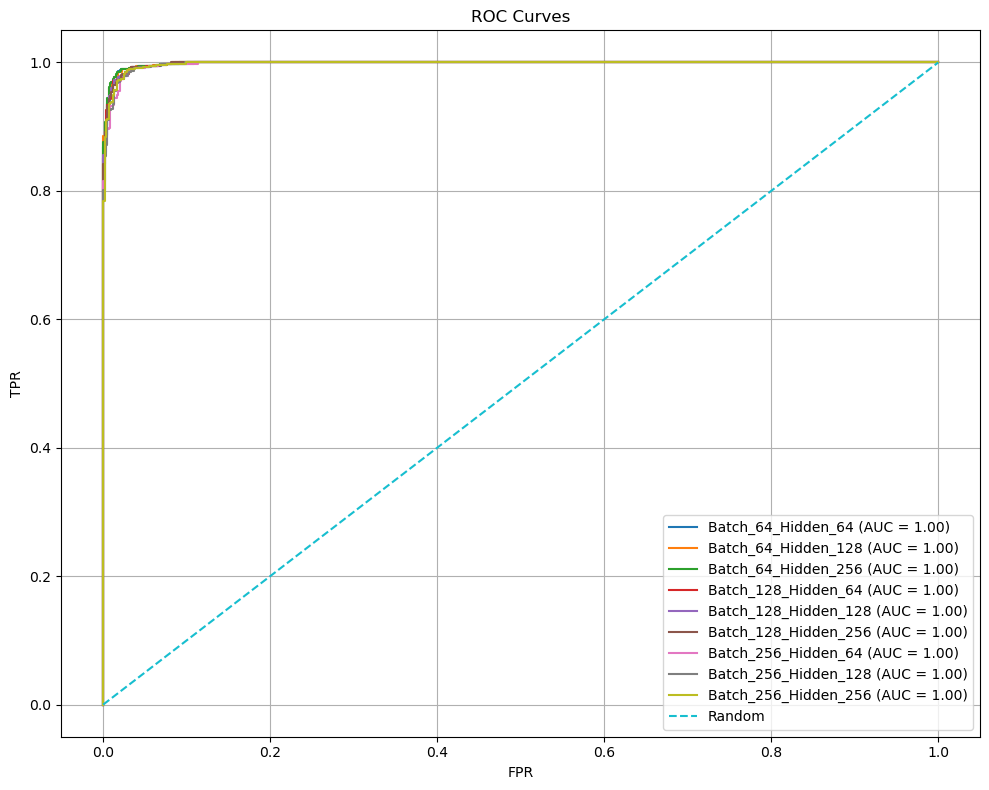

Best Model = Batch_64_Hidden_256 with AUC score = 0.9987141102940161


'Batch_64_Hidden_256'

In [14]:
mlp(X_train35, X_test35, X_val35, y_train35, y_test35, y_val35)

## 4 and 9

Trying model with h1 = 64
Trying model with h1 = 128
Trying model with h1 = 256
Trying model with h1 = 64
Trying model with h1 = 128
Trying model with h1 = 256
Trying model with h1 = 64
Trying model with h1 = 128
Trying model with h1 = 256


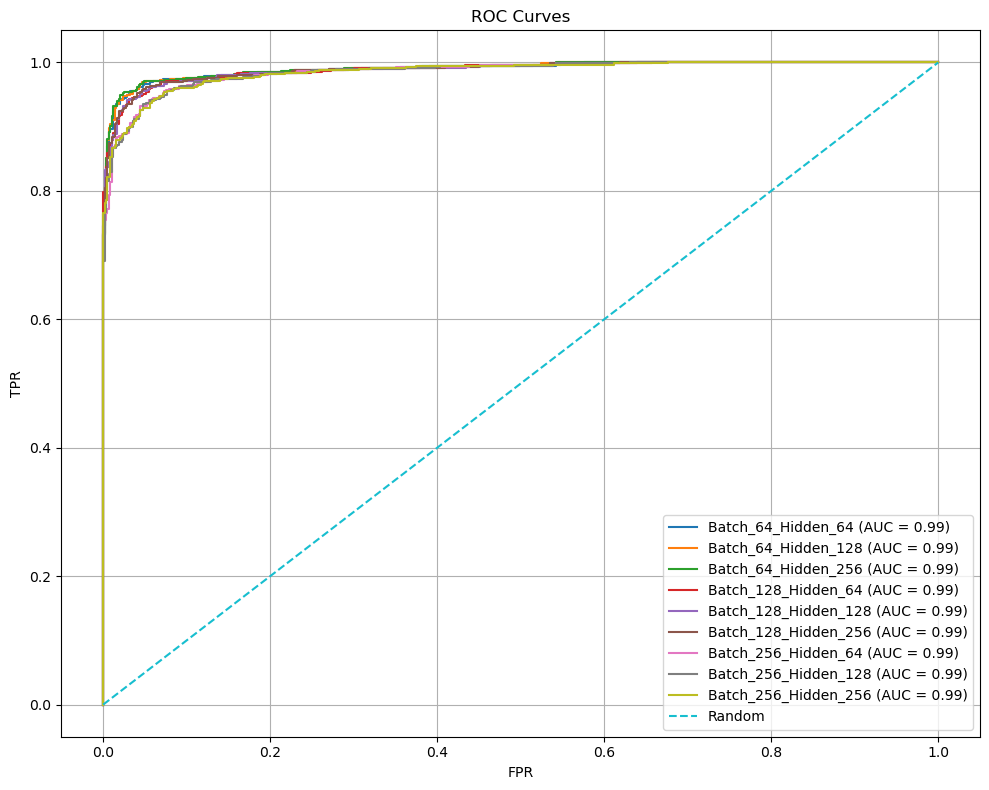

Best Model = Batch_64_Hidden_256 with AUC score = 0.9906988584072529


'Batch_64_Hidden_256'

In [15]:
mlp(X_train49, X_test49, X_val49, y_train49, y_test49, y_val49)

# Part (b)

In [16]:
#Logreg model
def logistic_regression(X_train, X_test, Y_train, Y_test):
    #model format
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, Y_train)

    #
    probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(Y_test, probs)
    fpr, tpr, _ = roc_curve(Y_test, probs)
    plt.plot(fpr, tpr, label=f"LogReg AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--', label = "Random")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()
    print(f"AUC Score = {auc}")
    return auc


## 3 and 5

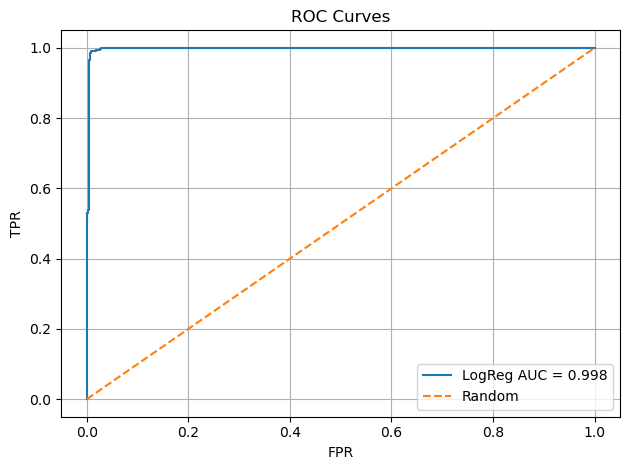

AUC Score = 0.9976987108143202


0.9976987108143202

In [17]:
logistic_regression(X_train35, X_test35, y_train35, y_test35)

The AUC scores from the MLP and logistic regression seem to be similar at around 0.99. The MLP does seem to perform a bit better with a slightly higher AUC score compared to logistic regression.

## 4 and 9

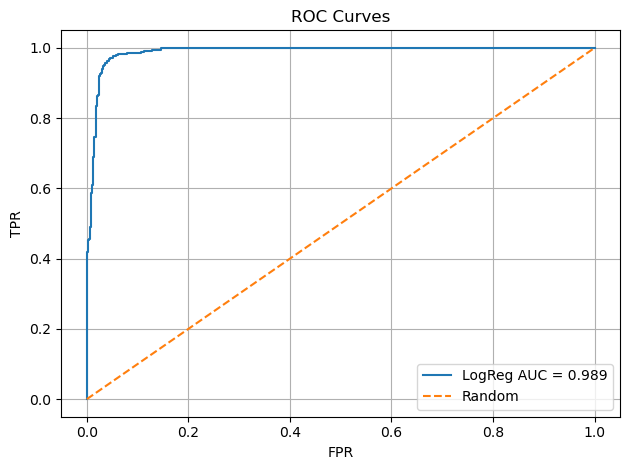

AUC Score = 0.9887441453552264


0.9887441453552264

In [18]:
logistic_regression(X_train49, X_test49, y_train49, y_test49)

Like 3 and 5, the AUC scores for the logistic regression and MLP seem to be similar however, the MLP performs better than the logistic regression for 4 and 9 of an AUC score of about 0.99 compared to about 0.988. In conclusion, both digit classifiers seem to perform better with the MLP compared to a standard logistic regression model.